In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from typing import Tuple
from scipy.stats import pearsonr
import numpy as np
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

In [3]:
def rank_biserial_correlation(x: pd.Series, y: pd.Series) -> Tuple[float, str]:
    """
    Compute rank-biserial correlation from two independent samples.
    """

    nx = len(x)
    ny = len(y)

    U, _ = mannwhitneyu(x, y, alternative='two-sided')
    rbc = 1 - (2 * U) / (nx * ny)

    abs_rbc = abs(rbc)
    if abs_rbc < 0.1:
        interpretation = "negligible"
    elif abs_rbc < 0.3:
        interpretation = "small"
    elif abs_rbc < 0.5:
        interpretation = "medium"
    else:
        interpretation = "large"

    return rbc, interpretation

In [4]:
def cliffs_delta(x: pd.Series, y: pd.Series) -> Tuple[float, str]:
    """
    Compute Cliff's Delta and return interpretation.
    """
    nx = len(x)
    ny = len(y)
    greater = sum(xi > yj for xi in x for yj in y)
    less = sum(xi < yj for xi in x for yj in y)
    delta = (greater - less) / (nx * ny)

    abs_delta = abs(delta)
    if abs_delta < 0.147:
        interpretation = "negligible"
    elif abs_delta < 0.33:
        interpretation = "small"
    elif abs_delta < 0.474:
        interpretation = "medium"
    else:
        interpretation = "large"
    return delta, interpretation

In [5]:
def classify_cortisol_level(value):
    if value > 20:
        return "High"
    elif value < 10:
        return "Low"
    else:
        return "Moderate"

In [6]:
df_data_iga = pd.read_csv("../processed_data/1_processed_data_IgA.csv")
print(df_data_iga.shape)
df_data_iga.head(5)

(35, 12)


,ID,Gender,age_baby_1,age_baby_2,age_baby_5,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment
0,1,Male,5,7.0,15.0,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure
1,4,Male,10,10.0,16.0,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure
2,5,Female,5,NaN,14.0,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure
3,7,Female,12,12.0,18.0,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure
4,11,Male,8,9.0,NaN,78.013279,382.715268,345.590046,4.196295,5.947291,1.750996,Insecure


In [7]:
df_data_cortisol = pd.read_csv("../processed_data/2_processed_data_cortisol.csv")
print(df_data_cortisol.shape)
df_data_cortisol.head(5)

(8, 10)


,ID,Cortisol (pg/mL),Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment
0,16.0,3.59,Female,57.476955,73.891936,16.414980,3.974519,4.178677,0.204158,Secure
1,32.0,22.75,Male,32.565326,44.611069,12.045743,3.417520,3.749981,0.332461,Secure
2,1.0,5.62,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure
3,7.0,1.83,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure
4,5.0,2.28,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure


In [8]:
df_data_cortisol["Log-transformed Cortisol (pg/mL)"] = np.log(df_data_cortisol["Cortisol (pg/mL)"].values)

In [9]:
df_merge = df_data_iga.merge(right=df_data_cortisol, on="ID")
df_merge.shape

(8, 22)

In [10]:
df_merge.head(5)

,ID,Gender_x,age_baby_1,age_baby_2,age_baby_5,sIgA_Average_Morning_x,sIgA_Average_Afternoon_x,sIgA_Average_Difference_x,sIgA_Average_Morning_log_x,sIgA_Average_Afternoon_log_x,...,Cortisol (pg/mL),Gender_y,sIgA_Average_Morning_y,sIgA_Average_Afternoon_y,sIgA_Average_Difference_y,sIgA_Average_Morning_log_y,sIgA_Average_Afternoon_log_y,sIgA_Average_Difference_log_y,Attachment_y,Log-transformed Cortisol (pg/mL)
0,1,Male,5,7.0,15.0,21.765240,28.368055,6.602815,3.077296,3.338237,...,5.62,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure,1.726332
1,5,Female,5,NaN,14.0,161.424693,46.867951,-114.556742,5.084039,3.847334,...,2.28,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure,0.824175
2,7,Female,12,12.0,18.0,24.173487,35.942378,14.343241,3.179553,3.581917,...,1.83,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure,0.604316
3,16,Female,11,11.0,17.0,57.476955,73.891936,16.414980,3.974519,4.178677,...,3.59,Female,57.476955,73.891936,16.414980,3.974519,4.178677,0.204158,Secure,1.278152
4,23,Female,7,8.0,14.0,80.824884,47.632842,-33.192041,4.392023,3.846883,...,4.76,Female,80.824884,47.632842,-33.192041,4.392023,3.846883,-0.545141,Secure,1.560248


In [11]:
df_merge.columns

Index(['ID', 'Gender_x', 'age_baby_1', 'age_baby_2', 'age_baby_5',
       'sIgA_Average_Morning_x', 'sIgA_Average_Afternoon_x',
       'sIgA_Average_Difference_x', 'sIgA_Average_Morning_log_x',
       'sIgA_Average_Afternoon_log_x', 'sIgA_Average_Difference_log_x',
       'Attachment_x', 'Cortisol (pg/mL)', 'Gender_y',
       'sIgA_Average_Morning_y', 'sIgA_Average_Afternoon_y',
       'sIgA_Average_Difference_y', 'sIgA_Average_Morning_log_y',
       'sIgA_Average_Afternoon_log_y', 'sIgA_Average_Difference_log_y',
       'Attachment_y', 'Log-transformed Cortisol (pg/mL)'],
      dtype='object')

In [12]:
df_merge = df_merge[['ID', 'Cortisol (pg/mL)', 'Gender_y',
       'sIgA_Average_Morning_y', 'sIgA_Average_Afternoon_y',
       'sIgA_Average_Difference_y', 'sIgA_Average_Morning_log_y',
       'sIgA_Average_Afternoon_log_y', 'sIgA_Average_Difference_log_y',
       'Attachment_y', 'Log-transformed Cortisol (pg/mL)']]

df_merge.columns = ['ID', 'Cortisol (pg/mL)', 'Gender',
       'sIgA_Average_Morning', 'sIgA_Average_Afternoon',
       'sIgA_Average_Difference', 'sIgA_Average_Morning_log',
       'sIgA_Average_Afternoon_log', 'sIgA_Average_Difference_log',
       'Attachment', 'Log-transformed Cortisol (pg/mL)']
df_merge.head(5)

,ID,Cortisol (pg/mL),Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment,Log-transformed Cortisol (pg/mL)
0,1,5.62,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure,1.726332
1,5,2.28,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure,0.824175
2,7,1.83,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure,0.604316
3,16,3.59,Female,57.476955,73.891936,16.414980,3.974519,4.178677,0.204158,Secure,1.278152
4,23,4.76,Female,80.824884,47.632842,-33.192041,4.392023,3.846883,-0.545141,Secure,1.560248


In [13]:
df_merge[df_merge["Attachment"] == "Secure"]["Log-transformed Cortisol (pg/mL)"].median()

np.float64(1.2781522025001875)

In [14]:
df_merge[df_merge["Attachment"] == "Insecure"]["Log-transformed Cortisol (pg/mL)"].median()

np.float64(1.7263316639055997)

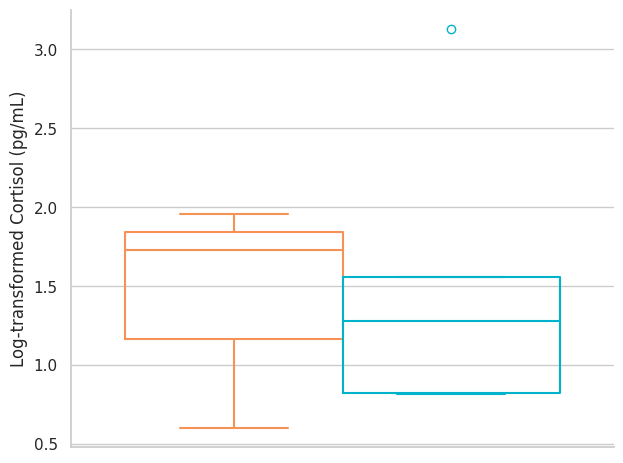

In [15]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}

sns.boxplot(
    data=df_merge, 
    y="Log-transformed Cortisol (pg/mL)", 
    hue="Attachment", 
    fill=False,
    palette=palette, 
    legend=False)

sns.despine()
plt.tight_layout()

In [23]:
data_for_figure_C = df_merge[["Log-transformed Cortisol (pg/mL)", "Attachment"]]
data_for_figure_C.to_csv("../data_for_figures/data_figure_C.csv", index=False)

In [16]:
variables = ["Log-transformed Cortisol (pg/mL)"]

attachment_comparison = []
for var in variables:
    secure_vals = df_merge[df_merge["Attachment"] == "Secure"][var]
    insecure_vals = df_merge[df_merge["Attachment"] == "Insecure"][var]
    stat, p = mannwhitneyu(secure_vals, insecure_vals, alternative='two-sided')
    statistic_result = {"variable": var, "U statistic": stat, "p-value": p}
    attachment_comparison.append(statistic_result)

attachment_comparison = pd.DataFrame(attachment_comparison)
attachment_comparison["reject"] = attachment_comparison["p-value"]<=0.05
attachment_comparison

,variable,U statistic,p-value,reject
0,Log-transformed Cortisol (pg/mL),7.0,1.0,False


In [17]:
attachment_cliffs = []
for var in variables:
    secure_vals = df_merge[df_merge["Attachment"] == "Secure"][var]
    insecure_vals = df_merge[df_merge["Attachment"] == "Insecure"][var]
    delta, interp = cliffs_delta(secure_vals, insecure_vals)
    attachment_cliffs.append({"variable": var, "Cliff's Delta": delta, "Interpretation": interp})

attachment_cliffs = pd.DataFrame(attachment_cliffs)
attachment_cliffs

,variable,Cliff's Delta,Interpretation
0,Log-transformed Cortisol (pg/mL),-0.066667,negligible


In [18]:
rbc_attachment = []
for var in variables:
    secure_vals = df_merge[df_merge["Attachment"] == "Secure"][var]
    insecure_vals = df_merge[df_merge["Attachment"] == "Insecure"][var]
    rbc, interp = rank_biserial_correlation(secure_vals, insecure_vals)
    rbc_attachment.append({"variable": var, "Rank-Biserial Corr": rbc, "Interpretation": interp})
rbc_attachment = pd.DataFrame(rbc_attachment)
rbc_attachment

,variable,Rank-Biserial Corr,Interpretation
0,Log-transformed Cortisol (pg/mL),0.066667,negligible


In [19]:
attachment_comparison.merge(right=attachment_cliffs, on="variable").merge(right=rbc_attachment, on="variable")

,variable,U statistic,p-value,reject,Cliff's Delta,Interpretation_x,Rank-Biserial Corr,Interpretation_y
0,Log-transformed Cortisol (pg/mL),7.0,1.0,False,-0.066667,negligible,0.066667,negligible


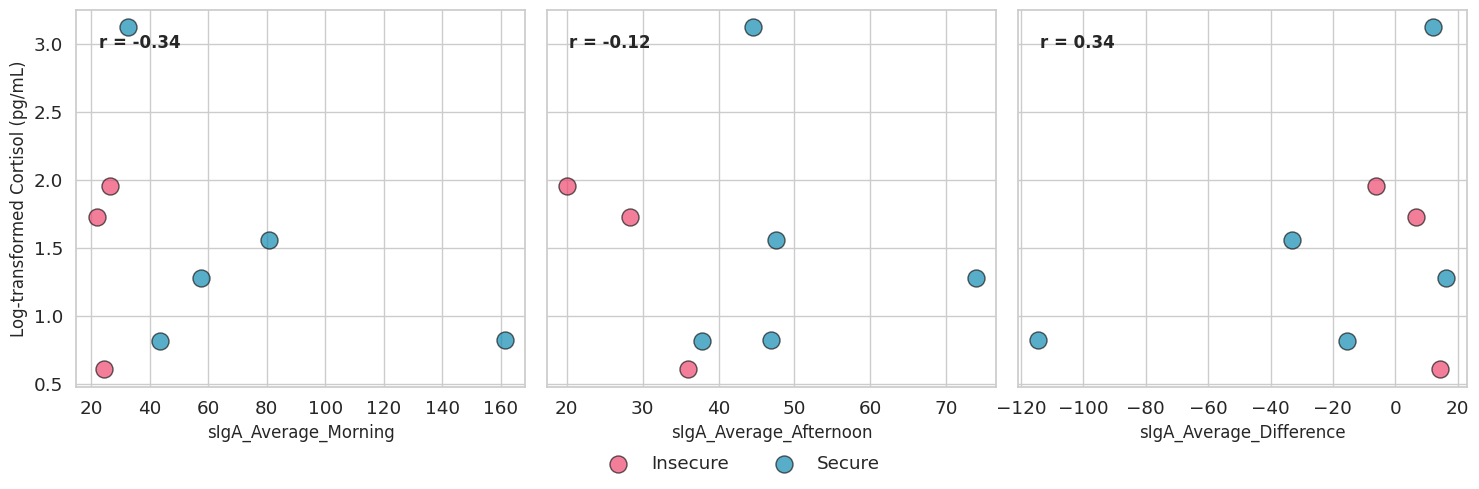

In [ ]:
sns.set(style="whitegrid", font_scale=1.2)
palette = {"Secure": "#118AB2", "Insecure": "#EF476F"}

x_vars = ["sIgA_Average_Morning", "sIgA_Average_Afternoon", "sIgA_Average_Difference"]
y_var = "Log-transformed Cortisol (pg/mL)"

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, x in enumerate(x_vars):
    ax = axes[i]

    for attachment, group in df_merge.groupby("Attachment"):
        ax.scatter(
            group[x], group[y_var],
            label=attachment if i == 0 else "", 
            alpha=0.7,
            s=150,
            edgecolor='k',
            color=palette[attachment]
        )
    
    ax.set_xlabel(x, fontsize=12)
    if i == 0:
        ax.set_ylabel(y_var, fontsize=12)
    else:
        ax.set_ylabel("")

    r, _ = pearsonr(df_merge[x], df_merge[y_var])
    ax.text(
        0.05, 0.9, f"r = {r:.2f}",
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold'
    )

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="", loc='lower center', ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])

In [25]:
data_for_figure_D = df_merge[["Attachment", "sIgA_Average_Morning_log", "sIgA_Average_Afternoon_log",
                              "sIgA_Average_Difference_log", "Log-transformed Cortisol (pg/mL)"]]
data_for_figure_D.to_csv("../data_for_figures/data_figure_D.csv", index=False)

In [21]:
df_merge.to_csv("../results_process/results_analysis_cortisol_iga_data.csv", index=False)